# NYC version28  Emergency Medical Response: Capacitated K-Center Clustering



## 1. Setup and Installations

> Add blockquote



In [2]:
!pip install geopandas folium networkx scikit-learn matplotlib seaborn -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import networkx as nx
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
print("✓ All packages loaded successfully")

✓ All packages loaded successfully


## 2. Data Loading and Preprocessing

In [3]:
from google.colab import files
print("Please upload your EMR_Incidents.csv file:")
uploaded = files.upload()

Please upload your EMR_Incidents.csv file:


Saving EMR_Incidents.csv to EMR_Incidents.csv


In [4]:
df = pd.read_csv("EMR_Incidents.csv")
print(f"Initial dataset: {len(df)} records")

df = df.dropna(subset=["Latitude", "Longitude"])
print(f"After removing missing coordinates: {len(df)} records")
df.head()

Initial dataset: 11750 records
After removing missing coordinates: 10125 records


,Borough,Creation Date,Latitude,Longitude
0,Queens,01/16/2017 1:13:38 PM,40.714004,-73.829989
1,Manhattan,10/29/2016 12:13:31 PM,40.714422,-74.006076
3,Queens,11/14/2016 3:53:54 PM,40.714004,-73.829989
5,Queens,12/02/2016 4:40:13 PM,40.714004,-73.829989
6,Manhattan,11/25/2016 4:06:09 AM,40.714422,-74.006076


In [5]:
def clean_nyc_data(df):
    """Filter data to valid NYC geographic bounds"""
    lat_min, lat_max = 40.4, 41.0
    lon_min, lon_max = -74.3, -73.6

    before = len(df)
    df = df[(df["Latitude"].between(lat_min, lat_max)) &
            (df["Longitude"].between(lon_min, lon_max))]
    after = len(df)

    print(f"Filtered out {before - after} outliers outside NYC bounds")
    return df.reset_index(drop=True)

df = clean_nyc_data(df)
print(f"Final dataset: {len(df)} valid incidents")

Filtered out 1 outliers outside NYC bounds
Final dataset: 10124 valid incidents


In [6]:
if "Borough" in df.columns:
    df["Borough_clean"] = df["Borough"].str.strip().str.lower()

    borough_map = {
        # Manhattan variants
        "manhattan": "Manhattan",
        "manhhattan": "Manhattan",
        "manhaatan": "Manhattan",
        "mahattan": "Manhattan",
        "mnahattan": "Manhattan",
        "manhatten": "Manhattan",
        "manhatan": "Manhattan",
        "manhttan": "Manhattan",
        "manhatta": "Manhattan",
        "mamhattan": "Manhattan",
        # Brooklyn variants
        "brooklyn": "Brooklyn",
        # Queens variants
        "queens": "Queens",
        "queen": "Queens",
        "quenns": "Queens",
        "flushing": "Queens",
        "rockaway": "Queens",
        "rockaway park": "Queens",
        "jamaica": "Queens",
        "jamaice": "Queens",
        "richmond hill": "Queens",
        "hollis": "Queens",
        "long island city": "Queens",
        "astoria": "Queens",
        "howard beach": "Queens",
        # Bronx variants
        "bronx": "Bronx",
        "brinx": "Bronx",
        # Staten Island variants
        "staten island": "Staten Island",
        "staten isalnd": "Staten Island",
        "saten island": "Staten Island",
    }

    df["Borough_clean"] = df["Borough_clean"].map(borough_map)
    df = df[df["Borough_clean"].isin(["Manhattan","Brooklyn","Queens","Bronx","Staten Island"])]

    print("\nIncidents per borough:")
    print(df["Borough_clean"].value_counts())


Incidents per borough:
Borough_clean
Manhattan        3335
Brooklyn         2628
Queens           1866
Bronx            1463
Staten Island     524
Name: count, dtype: int64


In [7]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    Returns distance in kilometers
    """
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Earth radius in kilometers
    r = 6371
    return c * r
def compute_distance_matrix(points1, points2=None):
    """
    Compute pairwise distances between points using Haversine
    points1, points2: arrays of shape (n, 2) with [lat, lon]
    """
    if points2 is None:
        points2 = points1
    n1, n2 = len(points1), len(points2)
    distances = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            distances[i, j] = haversine_distance(
                points1[i, 0], points1[i, 1],
                points2[j, 0], points2[j, 1]
            )

    return distances

# Test the distance function
print("Testing distance calculation:")
# Distance from Times Square to Statue of Liberty (should be ~8.5 km)
dist = haversine_distance(40.7580, -73.9855, 40.6892, -74.0445)
print(f"Times Square to Statue of Liberty: {dist:.2f} km")

Testing distance calculation:
Times Square to Statue of Liberty: 9.12 km


## 4. Basic K-Center Algorithm ()




In [9]:
def basic_k_center(X, k, distance_matrix=None, seed=42):
    """
    Basic K-Center using greedy farthest-first traversal

    Parameters:
    -----------
    X : array of shape (n, 2)
        Client locations [lat, lon]
    k : int
        Number of centers
    distance_matrix : array of shape (n, n), optional
        Precomputed distance matrix
    seed : int
        Random seed for reproducibility
    Returns:
    --------
    centers_idx : list
        Indices of selected centers
    """

    np.random.seed(seed)
    n = len(X)
    # Compute distance matrix if not provided
    if distance_matrix is None:
        print("Computing distance matrix")
        distance_matrix = compute_distance_matrix(X)
    # Initialize with random center
    centers = [np.random.choice(n)]
    # Greedily add k-1 more centers
    for _ in range(k - 1):
        # Distance from each point to nearest center
        min_dists = distance_matrix[:, centers].min(axis=1)
        # Select point farthest from all centers
        next_center = np.argmax(min_dists)
        centers.append(next_center)
    return centers
# Test with small k
print("Testing basic K-Center with k=5...")
X = df[["Latitude", "Longitude"]].values
centers_basic = basic_k_center(X, k=5)
print(f"Selected centers at indices: {centers_basic}")

Testing basic K-Center with k=5...
Computing distance matrix
Selected centers at indices: [7270, np.int64(2762), np.int64(5812), np.int64(8507), np.int64(3188)]




```
# This is formatted as code
```

## 5. Capacitated K-Center Algorithm


In [ ]:
def compute_initial_clustering(X, k):
    """
    Step 1: Find vanilla clustering via KMeans (approximates coreset)
    Returns initial facilities S' and radius r'
    """
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)

    # Initial facilities (cluster centers)
    S_prime = kmeans.cluster_centers_

    # Compute radius r' (max distance from any point to its assigned center)
    distances = compute_distance_matrix(X, S_prime)
    min_distances = distances.min(axis=1)
    r_prime = min_distances.max()

    return S_prime, r_prime

# Test initial clustering
print("Computing initial clustering...")
S_prime, r_prime = compute_initial_clustering(X, k=5)
print(f"Initial radius r': {r_prime:.3f} km")
print(f"Initial facilities shape: {S_prime.shape}")

Computing initial clustering...
Initial radius r': 23.778 km
Initial facilities shape: (5, 2)


In [ ]:
def build_flow_network(C, F, capacity, r, r_prime, dist_CF, dist_FF):
    """
    Build max-flow network for capacity-constrained assignment

    Parameters:
    -----------
    C : array of shape (n_clients, 2)
        Client locations
    F : array of shape (n_facilities, 2)
        Facility locations
    capacity : int
        Maximum clients per facility
    r : float
        Current radius being tested
    r_prime : float
        Radius from initial clustering
    dist_CF : array of shape (n_clients, n_facilities)
        Distance matrix from clients to facilities
    dist_FF : array of shape (n_facilities, n_facilities)
        Distance matrix between facilities

    Returns:
    --------
    G : NetworkX DiGraph
        Flow network with capacities
    """
    n_clients = len(C)
    n_facilities = len(F)

    # Create directed graph
    G = nx.DiGraph()

    # Add source and sink
    source = 'source'
    sink = 'sink'
    G.add_node(source)
    G.add_node(sink)

    # Add client nodes (one per client)
    client_nodes = [f'c_{i}' for i in range(n_clients)]
    G.add_nodes_from(client_nodes)

    # Add facility nodes (one per facility)
    facility_nodes = [f'f_{j}' for j in range(n_facilities)]
    G.add_nodes_from(facility_nodes)

    # Edge 1: Source to each client (capacity 1)
    for client_node in client_nodes:
        G.add_edge(source, client_node, capacity=1)

    # Edge 2: Each facility to sink (capacity U)
    for facility_node in facility_nodes:
        G.add_edge(facility_node, sink, capacity=capacity)

    # Edge 3: Client to facility (capacity 1, with distance constraints)
    # For each facility f' in S':
    for f_idx in range(n_facilities):
        # C'_f: clients within distance r + r' from f'
        eligible_clients = np.where(dist_CF[:, f_idx] <= r + r_prime)[0]

        # F'_f: facilities within distance r' from f'
        eligible_facilities = np.where(dist_FF[f_idx, :] <= r_prime)[0]

        # Connect eligible client-facility pairs
        for c_idx in eligible_clients:
            for eligible_f_idx in eligible_facilities:
                # Only add edge if actual distance <= r + r'
                if dist_CF[c_idx, eligible_f_idx] <= r + r_prime:
                    G.add_edge(
                        client_nodes[c_idx],
                        facility_nodes[eligible_f_idx],
                        capacity=1
                    )

    return G, client_nodes, facility_nodes

print("Flow network builder ready")

Flow network builder ready


In [ ]:
def capacitated_k_center(C, k, capacity, max_iterations=15):
    """
    Main algorithm: Capacitated K-Center with max-flow
    Parameters:
    -----------
    C : array of shape (n, 2)
        Client locations [lat, lon]
    k : int
        Number of facilities
    capacity : int
        Maximum clients per facility
    max_iterations : int
        Maximum radii to test (for computational efficiency)
    Returns:
    --------
    best_solution : dict
        Contains facilities, assignments, radius, flow value
    """
    n = len(C)
    print(f"\n{'='*60}")
    print(f"CAPACITATED K-CENTER ALGORITHM")
    print(f"{'='*60}")
    print(f"Clients: {n} | Facilities: {k} | Capacity: {capacity}")
    print(f"{'='*60}\n")

    # Step 1: Find initial clustering (vanilla clustering via coreset)
    print("[Step 1/4] Computing initial clustering...")
    S_prime, r_prime = compute_initial_clustering(C, k)
    print(f"  → Initial radius r' = {r_prime:.3f} km")

    # Step 2: Build distance set R (all unique distances)
    print("\n[Step 2/4] Computing distance matrices...")
    dist_CC = compute_distance_matrix(C, C)
    dist_CF = compute_distance_matrix(C, S_prime)
    dist_FF = compute_distance_matrix(S_prime, S_prime)

    # Get unique distances and sort
    all_distances = np.concatenate([dist_CC.flatten(), dist_CF.flatten()])
    R = np.unique(all_distances)
    R = R[R > 0]  # Remove zero distances

    print(f"  → {len(R)} unique distances computed")

    # CHANGED: More intelligent sampling strategy
    if len(R) > max_iterations:
        # Focus on the range around r_prime (where solutions are likely)
        # Sample more densely in the critical range
        lower_bound = r_prime * 0.5  # Start from half of r_prime
        upper_bound = r_prime * 2.0  # Go up to 2x r_prime

        # Get distances in this range
        R_critical = R[(R >= lower_bound) & (R <= upper_bound)]

        if len(R_critical) > max_iterations:
            # Sample from critical range
            percentiles = np.linspace(0, 100, max_iterations)
            R_test = np.percentile(R_critical, percentiles)
        else:
            # Use all critical range distances
            R_test = R_critical

### The radiusm testing boundaries
        # Add boundary values
        R_test = np.sort(np.unique(np.concatenate([
            [R[R < lower_bound].max()] if len(R[R < lower_bound]) > 0 else [],
            R_test,
            [R[R > upper_bound].min()] if len(R[R > upper_bound]) > 0 else []
        ])))
    else:
        R_test = R

    print(f"  → Testing {len(R_test)} radius values\n")

    # Print radius details
    print("="*70)
    print("  SAMPLED RADII (R_test) - WHAT WE'RE TESTING")
    print("="*70)
    print(f"\n Testing {len(R_test)} radii")
    print(f"   Range: {R_test.min():.4f} km to {R_test.max():.4f} km")
    print(f"   Initial radius r' (from KMeans): {r_prime:.4f} km\n")

    print(f"{'Index':<8} {'Radius r (km)':<15} {'Network range (r+r\')':<20}")
    print("-" * 70)
    for i in range(min(5, len(R_test))):
        print(f"{i:<8} {R_test[i]:>10.4f}        {R_test[i] + r_prime:>10.4f}")
    if len(R_test) > 10:
        print("   ...")
        for i in range(max(5, len(R_test)-5), len(R_test)):
            print(f"{i:<8} {R_test[i]:>10.4f}        {R_test[i] + r_prime:>10.4f}")

    print("\n" + "="*70)
    print(f" Goal: Find smallest r where all clients can be assigned within capacity")
    print("="*70 + "\n")

    # Step 3: Binary search over radii
    print("[Step 3/4] Searching for optimal radius using binary search...")

    # CHANGED: Use binary search instead of testing all radii
    best_solution = None
    best_radius = float('inf')

    # First, find if any solution exists by testing max radius
    r_max = R_test[-1]
    G, client_nodes, facility_nodes = build_flow_network(
        C, S_prime, capacity, r_max, r_prime, dist_CF, dist_FF
    )

    try:
        flow_value, _ = nx.maximum_flow(G, 'source', 'sink')
        if flow_value < n:
            print(f"   No feasible solution exists even with max radius {r_max:.3f} km")
            print(f"  → Maximum achievable flow: {int(flow_value)}/{n}")
            print(f"  → Try increasing capacity or number of facilities")
            print(f"\n{'='*60}\n")
            return None
    except nx.NetworkXUnbounded:
        print(f"  Network construction error")
        return None

    print(f"  ✓ Solution exists with r_max = {r_max:.3f} km\n")

    # Binary search
    left_idx = 0
    right_idx = len(R_test) - 1
    iteration = 0

    while left_idx < right_idx:
        iteration += 1
        mid_idx = (left_idx + right_idx) // 2
        r = R_test[mid_idx]

        # Build flow network
        G, client_nodes, facility_nodes = build_flow_network(
            C, S_prime, capacity, r, r_prime, dist_CF, dist_FF
        )

        # Solve max-flow
        try:
            flow_value, flow_dict = nx.maximum_flow(G, 'source', 'sink')

            # Check if all clients are assigned
            if flow_value == n:
                # Extract assignments
                assignments = {}
                for c_idx, client_node in enumerate(client_nodes):
                    if client_node in flow_dict:
                        for facility_node, flow in flow_dict[client_node].items():
                            if flow > 0 and facility_node.startswith('f_'):
                                f_idx = int(facility_node.split('_')[1])
                                assignments[c_idx] = f_idx
                                break

                print(f"  Iteration {iteration}: r={r:.3f}km → ✓ FEASIBLE (flow={int(flow_value)}/{n})")

                # Update best solution
                best_radius = r
                best_solution = {
                    'facilities': S_prime.copy(),
                    'assignments': assignments,
                    'radius': r,
                    'flow_value': flow_value,
                    'capacity': capacity
                }

                # Search for smaller radius
                right_idx = mid_idx
            else:
                print(f"  Iteration {iteration}: r={r:.3f}km → ✗ Infeasible (flow={int(flow_value)}/{n})")
                # Need larger radius
                left_idx = mid_idx + 1

        except nx.NetworkXUnbounded:
            print(f"  Iteration {iteration}: r={r:.3f}km → Error (unbounded flow)")
            left_idx = mid_idx + 1
            continue

    # Step 4: Return best solution
    print(f"\n[Step 4/4] Optimization complete")
    if best_solution:
        print(f"  → Best radius found: {best_radius:.3f} km")
        print(f"  → All {n} clients successfully assigned")
        print(f"  → Capacity per facility: {capacity} clients")
    else:
        print("  → No feasible solution found (capacity too small)")

    print(f"\n{'='*60}\n")

    return best_solution

print("Capacitated K-Center algorithm ready")

Capacitated K-Center algorithm ready


In [ ]:
# Parameters
K = 5  # Number of emergency response centers
CAPACITY = len(X) // K + 50  # Capacity per center (with buffer)

print(f"\nExperiment Configuration:")
print(f"  Total incidents: {len(X)}")
print(f"  Number of centers (k): {K}")
print(f"  Capacity per center: {CAPACITY}")
print(f"  Average incidents per center: {len(X) / K:.1f}\n")


Experiment Configuration:
  Total incidents: 9816
  Number of centers (k): 5
  Capacity per center: 2013
  Average incidents per center: 1963.2



In [ ]:
# Compute distance matrix once (for efficiency)
print("Computing distance matrix for all clients...")
distance_matrix = compute_distance_matrix(X)
print(f"Distance matrix shape: {distance_matrix.shape}\n")

Computing distance matrix for all clients...
Distance matrix shape: (9816, 9816)



In [15]:
# Run Capacitated K-Center
solution_capacitated = capacitated_k_center(X, k=K, capacity=CAPACITY, max_iterations=15)


CAPACITATED K-CENTER ALGORITHM
Clients: 9816 | Facilities: 5 | Capacity: 2013

[Step 1/4] Computing initial clustering...
  → Initial radius r' = 23.778 km

[Step 2/4] Computing distance matrices...
  → 21520070 unique distances computed
  → Testing 17 radius values

  SAMPLED RADII (R_test) - WHAT WE'RE TESTING

 Testing 17 radii
   Range: 11.8888 km to 47.5554 km
   Initial radius r' (from KMeans): 23.7776 km

Index    Radius r (km)   Network range (r+r')
----------------------------------------------------------------------
0           11.8888           35.6665
1           11.8888           35.6665
2           12.7134           36.4910
3           13.5454           37.3230
4           14.3965           38.1742
   ...
12          23.6586           47.4362
13          26.3068           50.0844
14          30.5479           54.3255
15          47.5550           71.3326
16          47.5554           71.3331

 Goal: Find smallest r where all clients can be assigned within capacity

[Ste

## 7. Performance Comparison

## 8. Visualizations

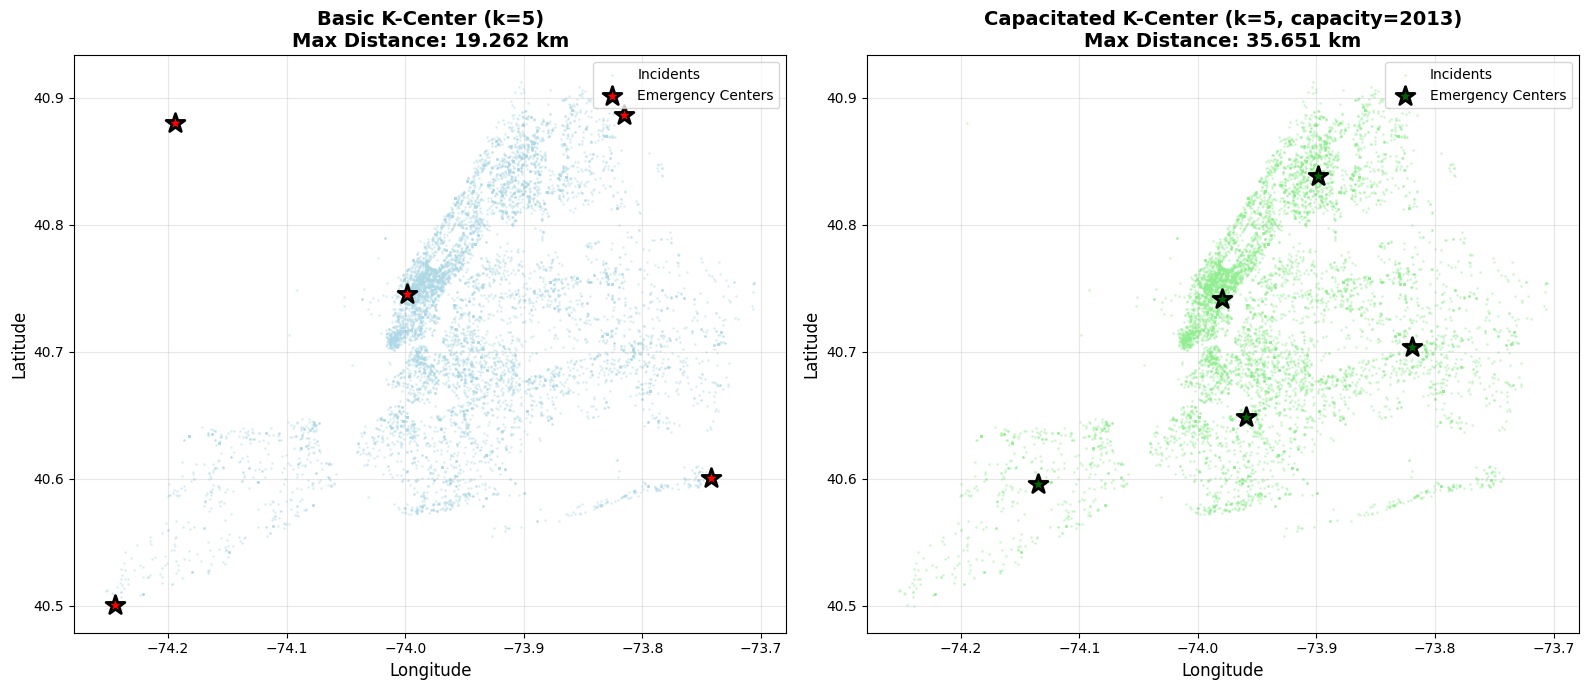


✓ Comparison visualization saved as 'comparison_map.png'


In [18]:
# Static visualization comparing both approaches
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Basic K-Center
ax = axes[0]
ax.scatter(X[:, 1], X[:, 0], c='lightblue', s=1, alpha=0.3, label='Incidents')
ax.scatter(facilities_basic[:, 1], facilities_basic[:, 0],
           c='red', s=200, marker='*', edgecolors='black', linewidths=2,
           label='Emergency Centers', zorder=5)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Basic K-Center (k={K})\nMax Distance: {basic_metrics["max_distance"]:.3f} km',
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Capacitated K-Center
if solution_capacitated:
    ax = axes[1]
    ax.scatter(X[:, 1], X[:, 0], c='lightgreen', s=1, alpha=0.3, label='Incidents')
    ax.scatter(facilities_cap[:, 1], facilities_cap[:, 0],
               c='darkgreen', s=200, marker='*', edgecolors='black', linewidths=2,
               label='Emergency Centers', zorder=5)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(f'Capacitated K-Center (k={K}, capacity={CAPACITY})\nMax Distance: {cap_metrics["max_distance"]:.3f} km',
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_map.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Comparison visualization saved as 'comparison_map.png'")

## 9. Scalability Analysis

In [20]:
# Test different k values
print("\nRunning scalability analysis...\n")

k_values = [5]
results_comparison = []

for k_test in k_values:
    print(f"\n{'='*60}")
    print(f"Testing k = {k_test}")
    print(f"{'='*60}")

    capacity_test = len(X) // k_test + 100

    # Basic K-Center
    centers = basic_k_center(X, k=k_test, distance_matrix=distance_matrix)
    dists = distance_matrix[:, centers].min(axis=1)

    results_comparison.append({
        'k': k_test,
        'method': 'Basic K-Center',
        'avg_distance': dists.mean(),
        'max_distance': dists.max(),
        'capacity': 'N/A'
    })

    # Capacitated K-Center (with fewer iterations for speed)
    sol = capacitated_k_center(X, k=k_test, capacity=capacity_test, max_iterations=10)

    if sol:
        cap_dists = []
        for c_idx, f_idx in sol['assignments'].items():
            dist = haversine_distance(
                X[c_idx, 0], X[c_idx, 1],
                sol['facilities'][f_idx, 0], sol['facilities'][f_idx, 1]
            )
            cap_dists.append(dist)

        results_comparison.append({
            'k': k_test,
            'method': 'Capacitated K-Center',
            'avg_distance': np.mean(cap_dists),
            'max_distance': np.max(cap_dists),
            'capacity': capacity_test
        })

# Create results DataFrame
results_df = pd.DataFrame(results_comparison)
print("\n" + "="*70)
print("SCALABILITY RESULTS")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)


Running scalability analysis...


Testing k = 5

CAPACITATED K-CENTER ALGORITHM
Clients: 9816 | Facilities: 5 | Capacity: 2063

[Step 1/4] Computing initial clustering...
  → Initial radius r' = 23.778 km

[Step 2/4] Computing distance matrices...
  → 21520070 unique distances computed
  → Testing 12 radius values

  SAMPLED RADII (R_test) - WHAT WE'RE TESTING

 Testing 12 radii
   Range: 11.8888 km to 47.5554 km
   Initial radius r' (from KMeans): 23.7776 km

Index    Radius r (km)   Network range (r+r')
----------------------------------------------------------------------
0           11.8888           35.6665
1           11.8888           35.6665
2           13.1734           36.9510
3           14.4917           38.2694
4           15.8396           39.6173
   ...
7           20.8043           44.5820
8           23.4238           47.2015
9           27.9381           51.7157
10          47.5550           71.3326
11          47.5554           71.3331

 Goal: Find smallest r where 

## 10. Key Findings and Conclusions

In [21]:
print("\n" + "="*70)
print("PROJECT CONCLUSIONS")
print("="*70)
print("\n2. PERFORMANCE TRADE-OFFS")
print("-" * 70)
if cap_metrics:
    print(f"Average Distance:")
    print(f"  Basic k center : {basic_metrics['avg_distance']:.3f} km")
    print(f"  Capacitated: {cap_metrics['avg_distance']:.3f} km")
    print(f"\nWorst-Case Distance:")
    print(f"  Basic: {basic_metrics['max_distance']:.3f} km")
    print(f"  Capacitated k-center: {cap_metrics['max_distance']:.3f} km")


PROJECT CONCLUSIONS

2. PERFORMANCE TRADE-OFFS
----------------------------------------------------------------------
Average Distance:
  Basic k center : 7.903 km
  Capacitated: 14.283 km

Worst-Case Distance:
  Basic: 19.262 km
  Capacitated k-center: 35.651 km
